In [1]:
pip install scikeras


Note: you may need to restart the kernel to use updated packages.


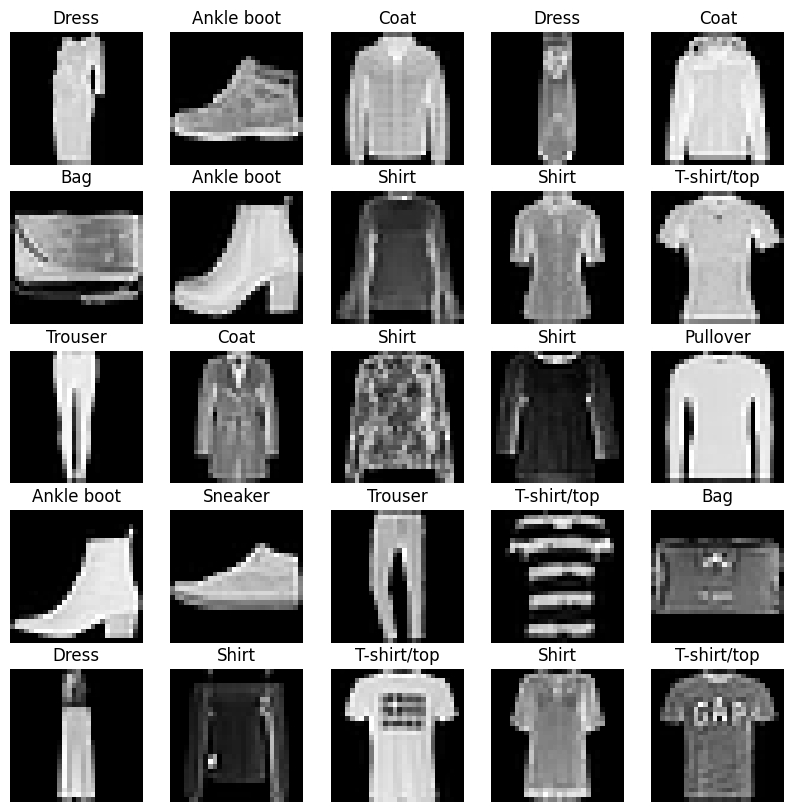

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   5.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.5s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   4.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   4.2s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   5.1s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  11.3s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  11.4s
[CV] END ......................C=0.1, gamma=auto

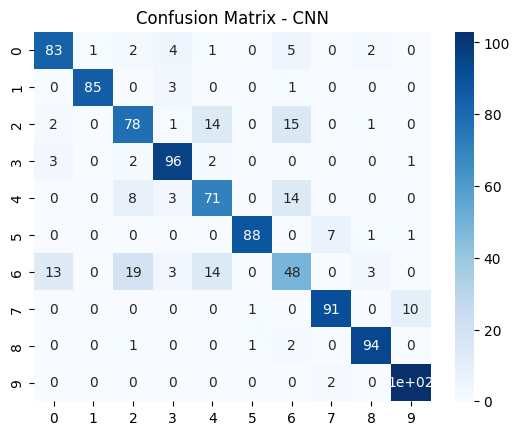

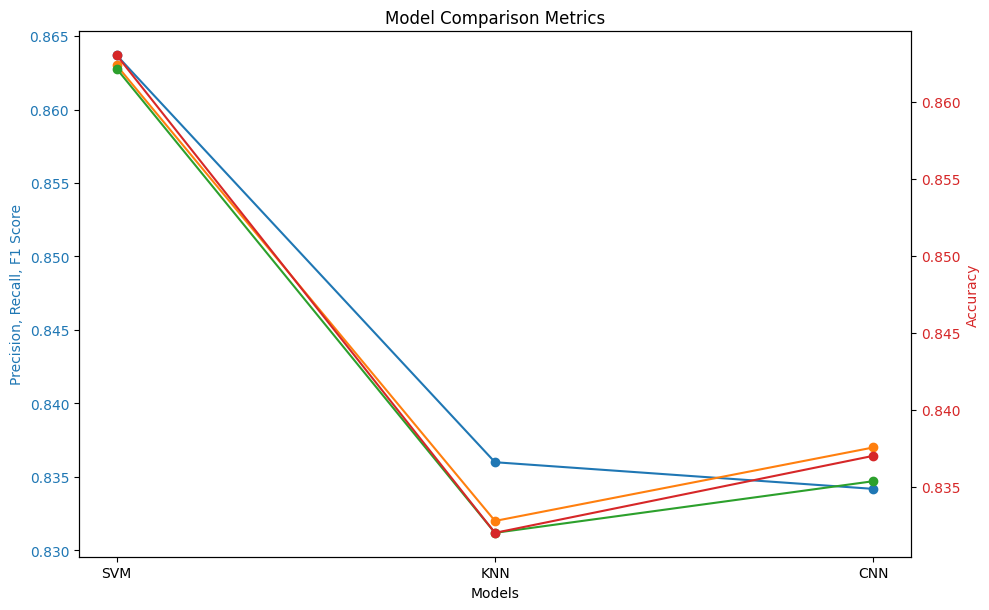

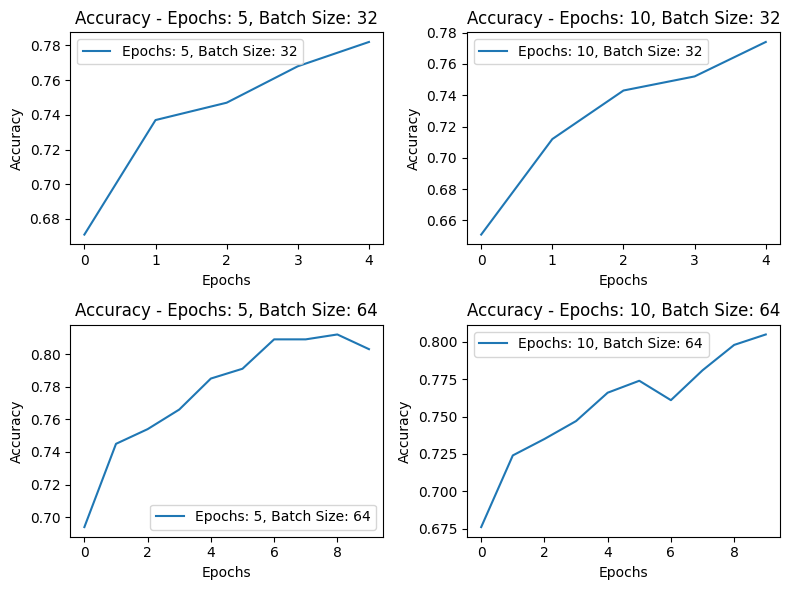

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import History
# Replace 'your_folder_path' with the path to the folder containing your CSV files.
folder_path = r'C:\Users\ashis\Downloads\fmnist'
train_file = "fashion-mnist_train.csv"
test_file = "fashion-mnist_test.csv"

# Construct full file paths
train_path = os.path.join(folder_path, train_file)
test_path = os.path.join(folder_path, test_file)

# Check if files exist
if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError("CSV files not found in the specified folder.")

# Load a subset of the data to reduce training time
train_data = pd.read_csv(train_path, nrows=5000)  # Use only 30,000 rows for training
test_data = pd.read_csv(test_path, nrows=1000)     # Use only 6,000 rows for testing

# Display random images from different classes
class_names = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    rand_index = np.random.randint(0, len(train_data))
    image = train_data.iloc[rand_index, 1:].values.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(class_names[train_data.iloc[rand_index, 0]])
    plt.axis('off')

plt.show()

# Data Acquisition and Preprocessing
X_train = normalize(train_data.iloc[:, 1:].values, axis=1)
X_test = normalize(test_data.iloc[:, 1:].values, axis=1)

X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)

y_train = to_categorical(train_data.iloc[:, 0].values, num_classes=10)
y_test = to_categorical(test_data.iloc[:, 0].values, num_classes=10)

# Hyperparameter tuning for SVM (GridSearchCV)
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(SVC(), param_grid=svm_param_grid, refit=True, verbose=2, cv=3)
svm_grid.fit(X_train, np.argmax(y_train, axis=1))

# Print the best hyperparameters for SVM
print("Best Hyperparameters for SVM:")
print(svm_grid.best_params_)

svm_model_tuned = svm_grid.best_estimator_

# Hyperparameter tuning for K-Nearest Neighbors (GridSearchCV)
knn_param_grid = {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_param_grid, refit=True, verbose=2, cv=3)
knn_grid.fit(X_train, np.argmax(y_train, axis=1))

# Print the best hyperparameters for K-Nearest Neighbors
print("Best Hyperparameters for K-Nearest Neighbors:")
print(knn_grid.best_params_)

knn_model_tuned = knn_grid.best_estimator_

# Hyperparameter tuning for CNN
def create_cnn_model(optimizer='adam', activation='relu'):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        Dropout(0.4),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform manual grid search for CNN hyperparameters
cnn_param_grid = {'optimizer': ['adam', 'sgd'], 'activation': ['relu', 'sigmoid']}
best_cnn_model = None
best_accuracy = 0.0
best_cnn_params = {'optimizer': None, 'activation': None}

# Perform grid search
for optimizer in cnn_param_grid['optimizer']:
    for activation in cnn_param_grid['activation']:
        current_cnn_model = create_cnn_model(optimizer=optimizer, activation=activation)
        current_cnn_model.fit(X_train_reshaped, y_train, epochs=5, verbose=0)
        _, current_accuracy = current_cnn_model.evaluate(X_test_reshaped, y_test, verbose=0)

        # Update best model if the current one is better
        if current_accuracy > best_accuracy:
            best_cnn_model = current_cnn_model
            best_accuracy = current_accuracy
            best_cnn_params['optimizer'] = optimizer
            best_cnn_params['activation'] = activation

# Print the best hyperparameters for CNN
print("Best Hyperparameters for CNN:")
print(best_cnn_params)

# Compile and fit the best Keras model
best_cnn_model.compile(optimizer=best_cnn_params['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'])
best_cnn_model.fit(X_train_reshaped, y_train, epochs=5, verbose=0)


# Model Evaluation
# Evaluate the best Keras model on the test set
cnn_accuracy = best_cnn_model.evaluate(X_test_reshaped, y_test, verbose=0)[1]

# Print accuracy
print(f"CNN Accuracy: {cnn_accuracy}")

# Use the most accurate method to classify the test data
svm_accuracy = svm_model_tuned.score(X_test, np.argmax(y_test, axis=1))
knn_accuracy = knn_model_tuned.score(X_test, np.argmax(y_test, axis=1))
cnn_accuracy = best_cnn_model.evaluate(X_test_reshaped, y_test, verbose=0)[1]

# Print accuracies
print(f"SVM Accuracy: {svm_accuracy}")
print(f"K-Nearest Neighbors Accuracy: {knn_accuracy}")
print(f"CNN Accuracy: {cnn_accuracy}")

# Use the most accurate method to classify the test data
most_accurate_method = max([(svm_accuracy, 'SVM'), (knn_accuracy, 'KNN'), (cnn_accuracy, 'CNN')], key=lambda x: x[0])[1]

if most_accurate_method == 'SVM':
    efficient_model = svm_model_tuned
    predictions = efficient_model.predict(X_test)
elif most_accurate_method == 'KNN':
    efficient_model = knn_model_tuned
    predictions = efficient_model.predict(X_test)
elif most_accurate_method == 'CNN':
    efficient_model = best_cnn_model
    predictions = np.argmax(efficient_model.predict(X_test_reshaped), axis=1)

# Store predictions in different variables according to the method
svm_predictions = svm_model_tuned.predict(X_test)
knn_predictions = knn_model_tuned.predict(X_test)
cnn_predictions = np.argmax(best_cnn_model.predict(X_test_reshaped), axis=1)

# Print classification reports
print("SVM Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), svm_predictions))

print("K-Nearest Neighbors Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), knn_predictions))

print("CNN Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), cnn_predictions))

# Confusion matrix for CNN
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), cnn_predictions), annot=True, cmap='Blues')
plt.title('Confusion Matrix - CNN')
plt.show()

# Comparative Analysis
# Compare the performance of different models graphically
models = ['SVM', 'KNN', 'CNN']
accuracy_scores = [svm_model_tuned.score(X_test, np.argmax(y_test, axis=1)),
                   knn_model_tuned.score(X_test, np.argmax(y_test, axis=1)),
                   best_cnn_model.evaluate(X_test_reshaped, y_test, verbose=0)[1]]

precision_scores = [precision_score(np.argmax(y_test, axis=1), svm_predictions, average='weighted'),
                    precision_score(np.argmax(y_test, axis=1), knn_predictions, average='weighted'),
                    precision_score(np.argmax(y_test, axis=1), cnn_predictions, average='weighted')]

recall_scores = [recall_score(np.argmax(y_test, axis=1), svm_predictions, average='weighted'),
                 recall_score(np.argmax(y_test, axis=1), knn_predictions, average='weighted'),
                 recall_score(np.argmax(y_test, axis=1), cnn_predictions, average='weighted')]

f1_scores = [f1_score(np.argmax(y_test, axis=1), svm_predictions, average='weighted'),
             f1_score(np.argmax(y_test, axis=1), knn_predictions, average='weighted'),
             f1_score(np.argmax(y_test, axis=1), cnn_predictions, average='weighted')]

# Plotting Line Plot for Comparative Analysis
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Models')
ax1.set_ylabel('Precision, Recall, F1 Score', color='tab:blue')
ax1.plot(models, precision_scores, marker='o', label='Precision', color='tab:blue')
ax1.plot(models, recall_scores, marker='o', label='Recall', color='tab:orange')
ax1.plot(models, f1_scores, marker='o', label='F1 Score', color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy', color='tab:red')  
ax2.plot(models, accuracy_scores, marker='o', label='Accuracy', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  
plt.title('Model Comparison Metrics')
plt.show()

# Varying Epochs and Batch Size Effect
def train_cnn_with_variation(epochs, batch_size):
    model = create_cnn_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = History()
    model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[history], verbose=0)
    return model, history

# Varying epochs and batch sizes
epochs_list = [5, 10]
batch_sizes_list = [32, 64]

accuracy_results = []
loss_results = []

for epochs in epochs_list:
    for batch_size in batch_sizes_list:
        cnn_model_variation, history_variation = train_cnn_with_variation(epochs, batch_size)
        accuracy_results.append(history_variation.history['val_accuracy'])
        loss_results.append(history_variation.history['val_loss'])

# Plotting
plt.figure(figsize=(8, 6))
for i, (epochs, batch_size) in enumerate(zip(epochs_list * len(batch_sizes_list), sorted(batch_sizes_list * len(epochs_list)))):
    plt.subplot(2, 2, i + 1)
    plt.plot(accuracy_results[i], label=f'Epochs: {epochs}, Batch Size: {batch_size}')
    plt.title(f'Accuracy - Epochs: {epochs}, Batch Size: {batch_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


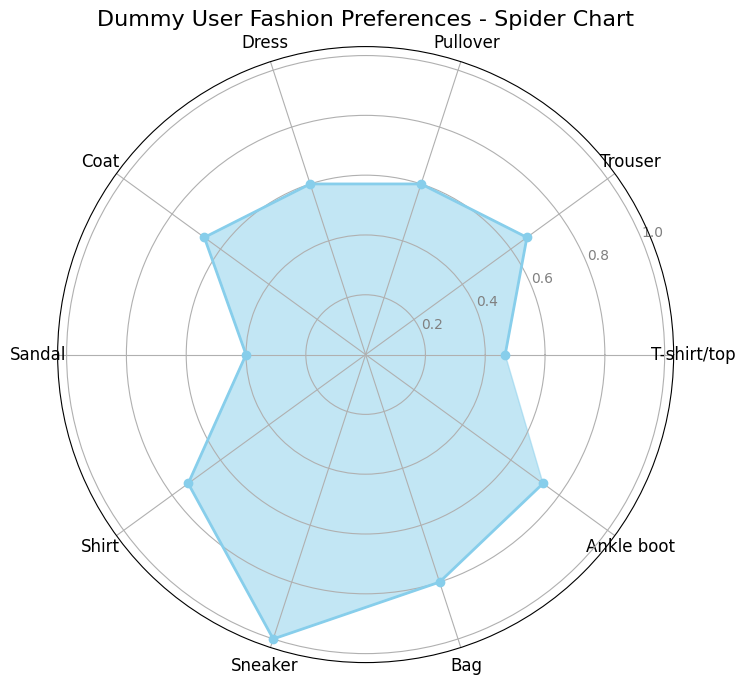

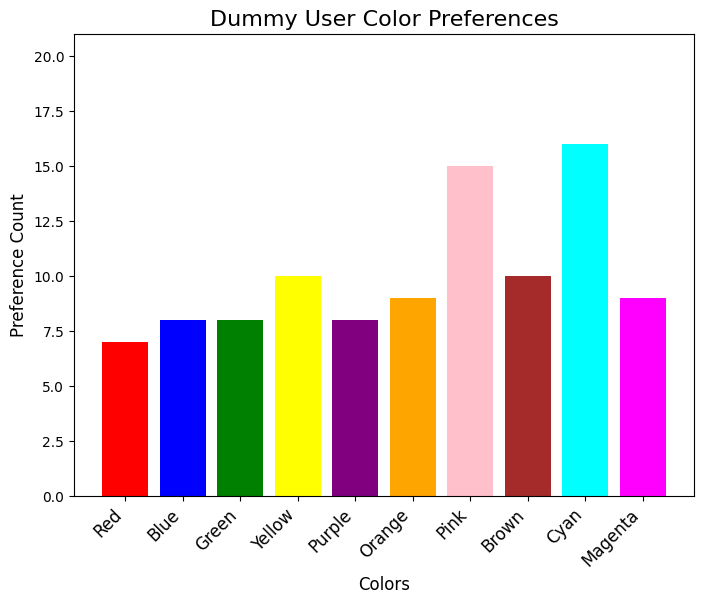

Top 2 Color Preferences: Index(['Red', 'Pink'], dtype='object', name='color')
Top 2 Class Preferences (0-9): Index([7, 8], dtype='int32', name='label')


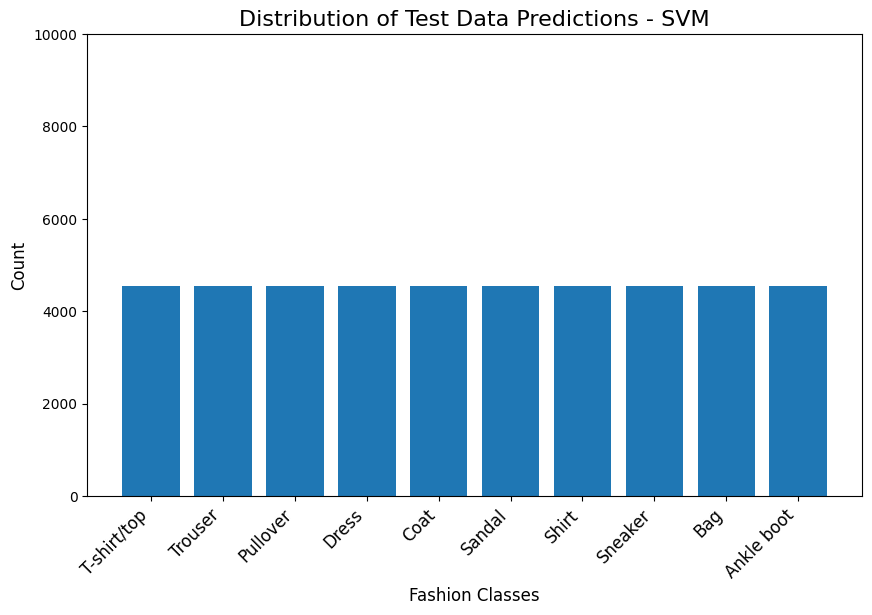


 Suggestions: 



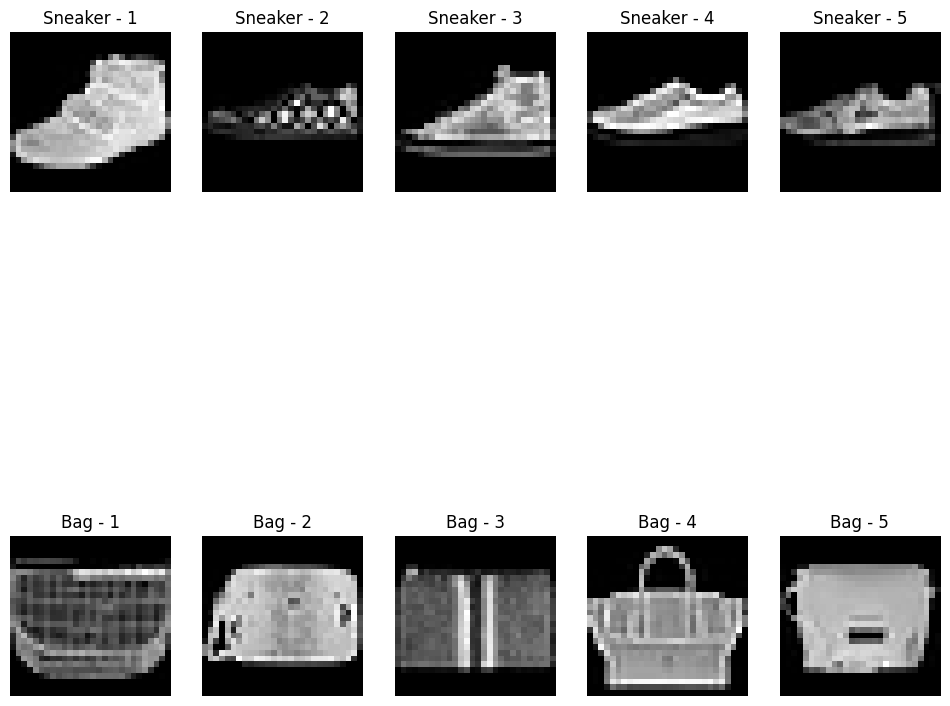

SVM Classification Report (Entire Test Set):
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        98
           1       1.00      0.97      0.98        89
           2       0.81      0.76      0.78       111
           3       0.90      0.90      0.90       104
           4       0.75      0.79      0.77        96
           5       0.99      0.91      0.95        97
           6       0.64      0.61      0.63       100
           7       0.91      0.95      0.93       102
           8       0.95      0.96      0.95        98
           9       0.94      0.97      0.96       105

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



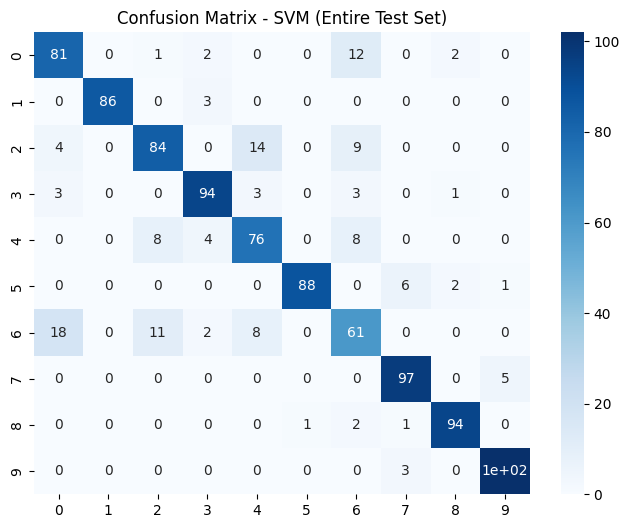

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Define known colors for the dummy user profile
known_colors = ['Red', 'Blue', 'Green', 'Yellow', 'Purple', 'Orange', 'Pink', 'Brown', 'Cyan', 'Magenta']

# 1. Create a dummy user profile purchase history
np.random.seed(42)
dummy_user_history = {
    'label': np.random.randint(0, 10, 100),
    'color': np.random.choice(known_colors, 100)
}
dummy_user_profile = pd.DataFrame(dummy_user_history)

# 2. Spider Chart Visualization for the dummy user profile
dummy_user_categories = list(class_names.values())
dummy_user_values = dummy_user_profile['label'].value_counts().sort_index().tolist()

normalized_dummy_user_values = [v / max(dummy_user_values) for v in dummy_user_values]

# Define angles based on the number of categories
num_categories = len(dummy_user_categories)
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

plt.figure(figsize=(8, 8))
plt.polar(angles, normalized_dummy_user_values, marker='o', linestyle='-', linewidth=2, color='skyblue')
plt.fill(angles, normalized_dummy_user_values, alpha=0.5, color='skyblue')
plt.title('Dummy User Fashion Preferences - Spider Chart', fontsize=16)
plt.xticks(angles, dummy_user_categories, fontsize=12)
plt.yticks(color='grey', size=10)
plt.show()

# Bar chart for color preferences in the dummy user profile with vibrant colors
dummy_user_color_preferences = dummy_user_profile['color'].value_counts().sort_index().tolist()

plt.figure(figsize=(8, 6))
plt.bar(known_colors, dummy_user_color_preferences, color=['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta'])
plt.title('Dummy User Color Preferences', fontsize=16)
plt.xlabel('Colors', fontsize=12)
plt.ylabel('Preference Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, max(dummy_user_color_preferences) + 5)  # Set y-axis limit to avoid overshooting
plt.show()

# Print the top 2 color preferences and top 2 class preferences
top_dummy_user_categories = dummy_user_profile['label'].value_counts().index[:2]
top_dummy_user_colors = dummy_user_profile['color'].value_counts().index[:2]

print('Top 2 Color Preferences:', top_dummy_user_colors)
print('Top 2 Class Preferences (0-9):', top_dummy_user_categories)

# 3. Use the most accurate method from Code1 to classify the test data
most_efficient_method = max([(svm_accuracy, 'SVM'), (knn_accuracy, 'KNN'), (cnn_accuracy, 'CNN')], key=lambda x: x[0])

if most_efficient_method[1] == 'SVM':
    efficient_model = svm_model_tuned
elif most_efficient_method[1] == 'KNN':
    efficient_model = knn_model_tuned
else:
    efficient_model = cnn_model_tuned

# Classify the test data and show the distribution according to class
efficient_model_predictions = efficient_model.predict(X_test)
class_distribution = np.sum(efficient_model_predictions, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(class_names.values(), class_distribution)
plt.title(f'Distribution of Test Data Predictions - {most_efficient_method[1]}', fontsize=16)
plt.xlabel('Fashion Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 10000)  # Adjust the upper limit based on your data
plt.show()


# 4. Show 5 images for each of the top 2 user-purchased classes in the test data
# based on the classification done in Code1 using the top 2 categories according to the dummy user preferences

# Select the top 2 classes based on dummy user preferences
dummy_user_top_classes = top_dummy_user_categories

print("\n Suggestions: \n")
# Display 5 images for each of the top 2 classes based on the most efficient model
plt.figure(figsize=(12, 12))

for i, category in enumerate(dummy_user_top_classes, 1):
    category_data = selected_test_data[selected_test_data['label'] == category]
    sample_images = category_data.sample(5, random_state=42)

    for j, (_, row) in enumerate(sample_images.iterrows(), 1):
        plt.subplot(2, 5, (i-1) * 5 + j)
        plt.imshow(row.values[1:].reshape(28, 28), cmap='gray')
        plt.title(f'{class_names[category]} - {j}')
        plt.axis('off')

plt.show()
# 5. Evaluate the most efficient method on the entire test set
efficient_model_predictions_entire = efficient_model.predict(X_test)

# Print classification report for the most efficient method on the entire test set
print(f"{most_efficient_method[1]} Classification Report (Entire Test Set):")
print(classification_report(np.argmax(y_test, axis=1), efficient_model_predictions_entire))

# Confusion matrix for the most efficient method on the entire test set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), efficient_model_predictions_entire), annot=True, cmap='Blues')
plt.title(f'Confusion Matrix - {most_efficient_method[1]} (Entire Test Set)')
plt.show()
